In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
import pymongo
import pymongo.database
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection
import sys

sys.path.append('../')
import src.IQ as IQ

## Connecting to the database

In [22]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/admin")
BLE = myclient["BLE"]

def query(collection, filter:dict, addFrameColumn=False):
    df =  pd.DataFrame(list(collection.find(filter)))
    if addFrameColumn:
        df['frame'] = df.apply(lambda x: x['I'] + np.dot(x['Q'],1j), axis=1)
    return df.copy()


In [23]:
def df_modify(df):
    if 'txPower' in df.columns:
        df_temp = df[['I','Q','frame','dvc','pos', 'antenna', 'txPower','SDR','frameChnl']].copy()
        df_temp['txPower'] = df.apply(lambda x: 9 if x['txPower'] == '9dbm' else 3, axis=1)
        df_temp[['dvc','pos', 'antenna', 'txPower','SDR','frameChnl']] = df_temp[['dvc','pos', 'antenna', 'txPower','SDR','frameChnl']].astype('int')
    else:
        df_temp = df[['I','Q','frame','dvc','pos', 'antenna', 'antenna_side','SDR','frameChnl']].copy()
        df_temp['antenna_side'] = df.apply(lambda x: 0 if x['antenna_side'] == 'left' else 1, axis=1)
        df_temp['pos'] = df.apply(lambda x: 0 if x['pos'] == 'static' else 1, axis=1)
        df_temp[['dvc','pos', 'antenna','SDR','frameChnl']] = df_temp[['dvc','pos', 'antenna','SDR','frameChnl']].astype('int')
    return df_temp.copy()

In [24]:
def df_to_tensor(df: pd.DataFrame):
    y = df.pop('dvc').to_numpy()-1
    X = df.to_numpy() 
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y ,
                                                                                random_state=104, 
                                                                                test_size=0.25, 
                                                                                shuffle=True
                                                                                )
    return torch.from_numpy(X_train).float(),torch.from_numpy(X_test).float(), torch.from_numpy(y_train).int(), torch.from_numpy(y_test).int()

In [25]:
df = query(BLE['offBody'], {'antenna': '1','SDR':'1','pos':'1' , 'dvc':'1'}, addFrameColumn=True)
df_offBody = df_modify(df)

In [26]:
# X_train, X_test, y_train, y_test = df_to_tensor(df_offBody)
# pd.DataFrame(df_offBody['I'].tolist())

y = df_offBody.pop('dvc')
X = df_offBody


100.0 1000.0 82.0


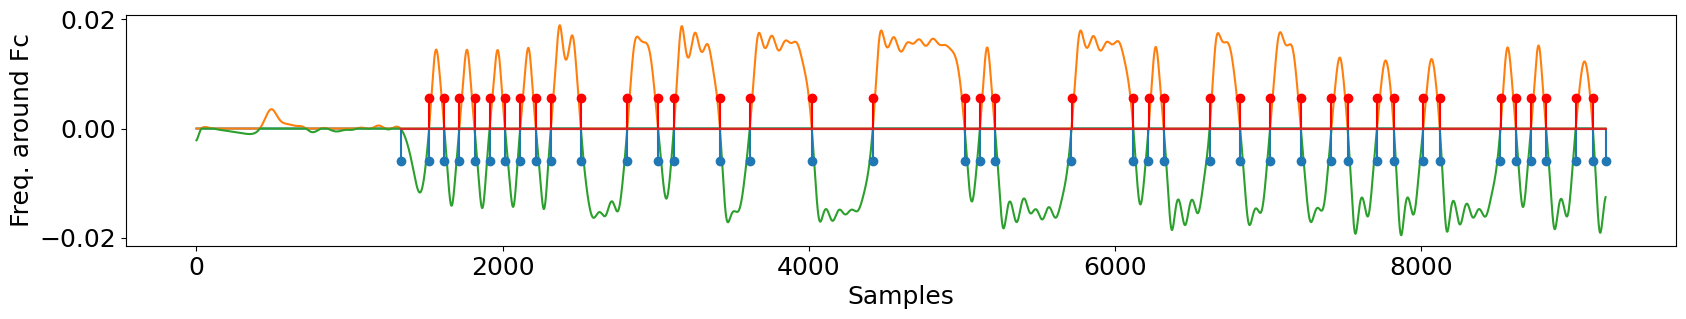

100.0 1000.0 82.0


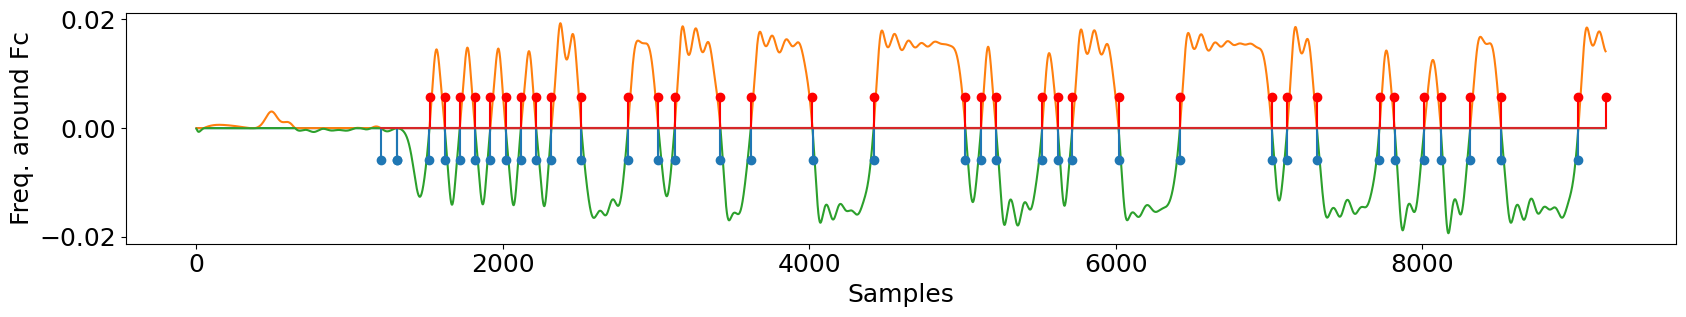

100.0 1000.0 82.0


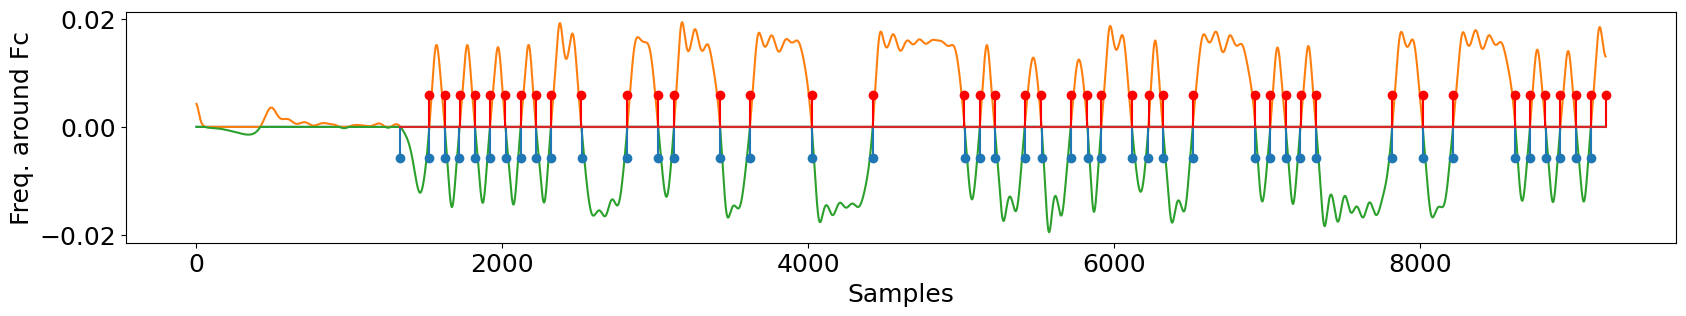

10.0 100 6


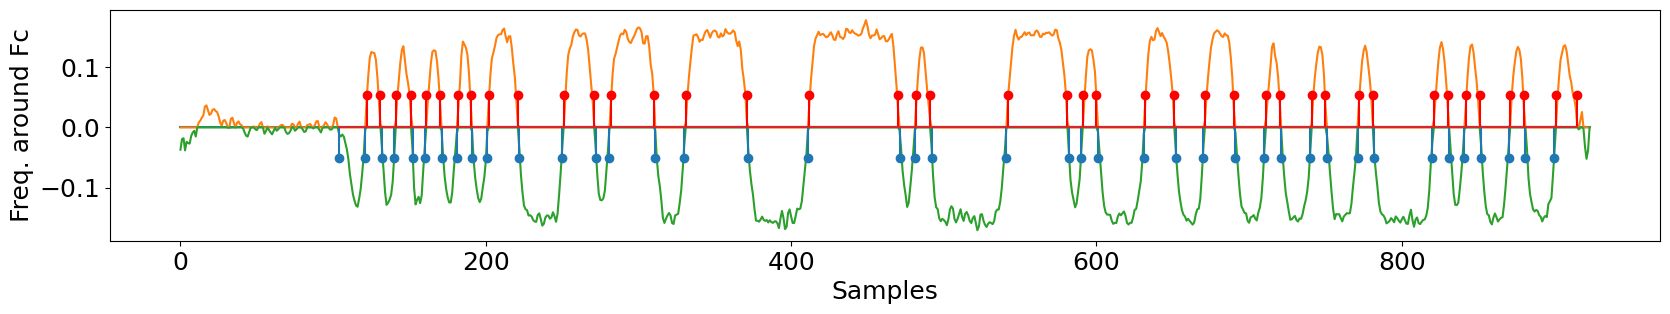

10.0 100 6


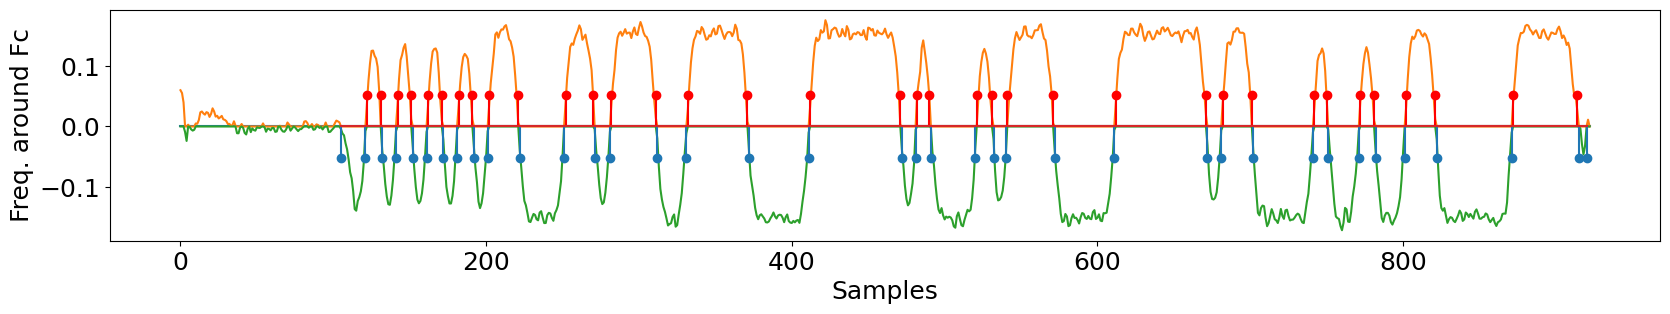

10.0 100 6


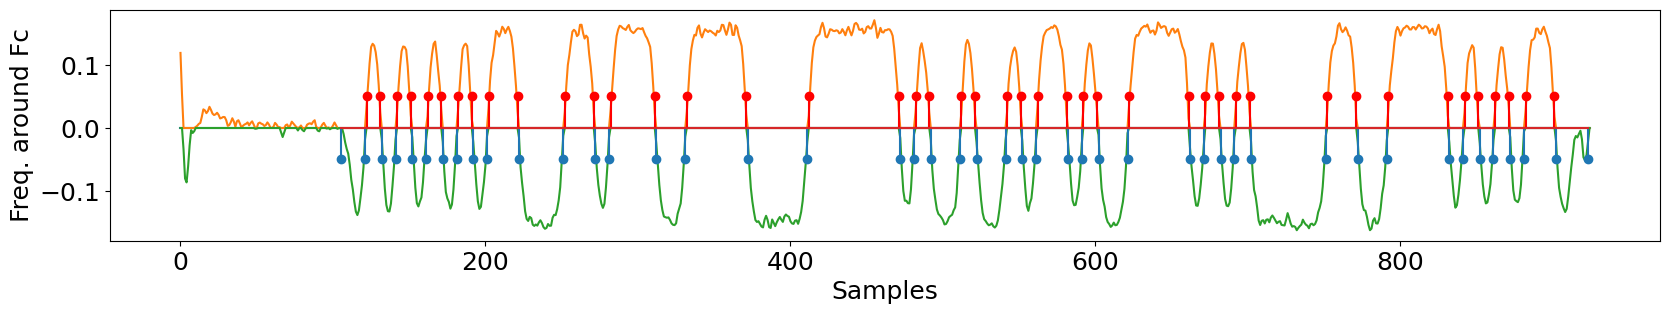

In [32]:
iq = IQ.IQ(Fc=2439810000+1.5e4,Fs=100e6)
plt.rcParams.update({'font.size': 18})

iq.Warnings = False
methods={ 
    iq.bitFinderFromPhaseGradient:{'plot': True, 'noGroupBefore':1200},
    iq.gradient:{},
    iq.unwrapPhase:{},
    iq.phase:{}, 
    iq.butter:{},
    iq.demodulate:{},
}
yy = iq.apply(methods=methods, frame = X[0:3])

# How DownSampling effects the signal
methods={
    # iq.bitPlotter:{'Fs': 10e6, 'title': 'Bit Finder'},
                                                
    iq.bitFinderFromPhaseGradient:{'Fs': 10e6, 'smallerThan': 100, 'biggerThan': 6, 'noGroupBefore': 100 , 'plot': True},
    iq.gradient:{},
    iq.unwrapPhase:{},
    iq.phase:{}, 
    # iq.butter:{'Fs': 10e6},
    iq.sinc:{'length':4},
    iq.downSample:{'downSampleRate':10},
    iq.demodulate:{'Fs': 100e6},
}
yy2 = iq.apply(methods=methods, frame = X[0:3])



In [33]:
print('Beg','End','len','slope', 'b_nr', '--', 'Beg','End','len','slope', 'b_nr')
for i in range(len(yy[0])):
    j = yy[0][i]
    k = yy2[0][i]
    # k = j
    print(j['indxBegining'],j['indxEnd'],j['len'],j['slope'], j['numberOfBits'], '--', k['indxBegining'],k['indxEnd'],k['len'],k['slope'], k['numberOfBits'])

Beg End len slope b_nr -- Beg End len slope b_nr
1333 1519 186 negative 1.86 -- 104 121 17 negative 1.7
1520 1618 98 positive 0.98 -- 122 131 9 positive 0.9
1619 1716 97 negative 0.97 -- 132 140 8 negative 0.8
1717 1816 99 positive 0.99 -- 141 151 10 positive 1.0
1817 1914 97 negative 0.97 -- 152 160 8 negative 0.8
1915 2015 100 positive 1.0 -- 161 170 9 positive 0.9
2016 2114 98 negative 0.98 -- 171 181 10 negative 1.0
2115 2216 101 positive 1.01 -- 182 190 8 positive 0.8
2217 2314 97 negative 0.97 -- 191 201 10 negative 1.0
2315 2510 195 positive 1.95 -- 202 221 19 positive 1.9
2511 2813 302 negative 3.02 -- 222 250 28 negative 2.8
2814 3015 201 positive 2.01 -- 251 271 20 positive 2.0
3016 3117 101 negative 1.01 -- 272 281 9 negative 0.9
3118 3418 300 positive 3.0 -- 282 310 28 positive 2.8
3419 3613 194 negative 1.94 -- 311 330 19 negative 1.9
3614 4019 405 positive 4.05 -- 331 371 40 positive 4.0
4020 4417 397 negative 3.97 -- 372 411 39 negative 3.9
4418 5017 599 positive 5.99 --

In [29]:
yy2

0    [{'samples': [0.04853117714325231, 0.085715589...
1    [{'samples': [0.0384459209787229, 0.0757105398...
2    [{'samples': [0.032987082079089305, 0.06813397...
dtype: object

In [30]:


# %%
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=6, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=10000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=10000, out_features=1000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1000, out_features=13),
)



In [31]:
ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

# %%
kl_weight = 0.1

# %%
for step in range(3000):
    pre = model(x)
    ce = ce_loss(pre, y)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

NameError: name 'x' is not defined